In [4]:
import pandas as pd
import matplotlib.pyplot as plt

### Dataset

In [5]:
# названия колонок
cols = [
    "fLength",
    "fWidth",
    "fSize",
    "fConc",
    "fConc1",
    "fAsym",
    "fM3Long",
    "fM3Trans",
    "fAlpha",
    "fDist",
    "class",
]

df = pd.read_csv("../data/magic04.data", names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [7]:
df.describe()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000,19020.000000
mean,53.250154,22.180966,2.825017,0.380327,0.214657,-4.331745,10.545545,0.249726,27.645707,193.818026
std,42.364855,18.346056,0.472599,0.182813,0.110511,59.206062,51.000118,20.827439,26.103621,74.731787
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,1.282600
25%,24.336000,11.863800,2.477100,0.235800,0.128475,-20.586550,-12.842775,-10.849375,5.547925,142.492250
50%,37.147700,17.139900,2.739600,0.354150,0.196500,4.013050,15.314100,0.666200,17.679500,191.851450
75%,70.122175,24.739475,3.101600,0.503700,0.285225,24.063700,35.837800,10.946425,45.883550,240.563825
max,334.177000,256.382000,5.323300,0.893000,0.675200,575.240700,238.321000,179.851000,90.000000,495.561000


In [8]:
df["class"].unique()

array(['g', 'h'], dtype=object)

In [9]:
# меняем g на 1, h на 0
df["class"] = (df["class"] == "g").astype(int)

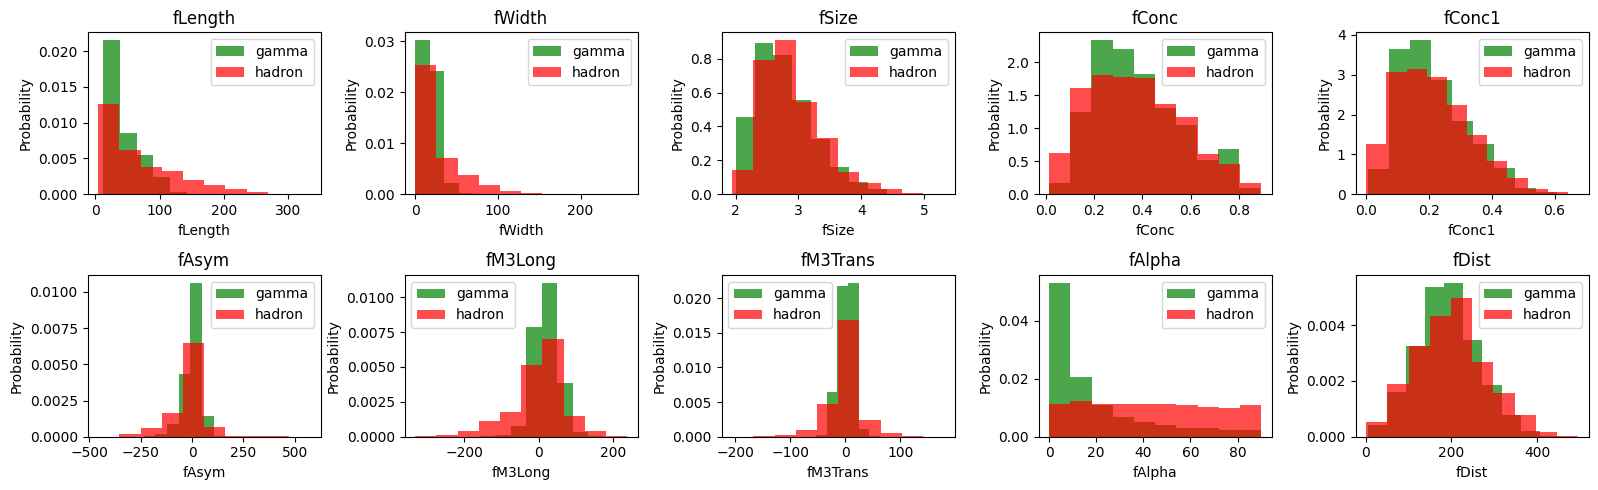

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(16, 5))
axes = axes.flatten()

for i, column in enumerate(cols[:-1]):
    ax = axes[i]
    ax.hist(
        df[df["class"] == 1][column],
        color="green",
        label="gamma",
        alpha=0.7,
        density=True,
    )
    ax.hist(
        df[df["class"] == 0][column],
        color="red",
        label="hadron",
        alpha=0.7,
        density=True,
    )
    ax.set(title=column, xlabel=column, ylabel="Probability")
    ax.legend()

plt.tight_layout()
plt.show()

##### Замечания по поводу признаков 

- fAlpha - по мере увеличения признака, вероятность gamma падает, вероятность hadron постоянна.
- fAsym, fM3Long, fLength - распределение вероятности gamma более сконцентрировано, в то время для hadron спад вероятности происходит более плавно
- у остальных признаков различия в распределении вероятности выражены меньше.

### Scaling and Oversampling

In [11]:
from sklearn.model_selection import train_test_split

# Сначала разделяем на тренировочную выборку (train) и временную выборку (temp), которая будет разделена на валидационную и тестовую
train, temp = train_test_split(df, test_size=0.3, random_state=42)

# Затем делим временную выборку (temp) на валидационную (valid) и тестовую (test)
valid, test = train_test_split(temp, test_size=0.5, random_state=42)

In [12]:
print(f"Количество примеров gamma: {(train['class'] == 1).sum()}")
print(f"Количество примеров hadron: {(train['class'] == 0).sum()}")

Количество примеров gamma: 8627
Количество примеров hadron: 4687


In [13]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler


def scale_and_oversample(df, oversample=False):
    X = df[df.columns[:-1]].values  # Все колонки кроме последней
    y = df[df.columns[-1]].values  # Последняя колонка - это целевая переменная (class)

    # Масштабируем признаки
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        # Применяем овер-сэмплинг
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = pd.DataFrame(X, columns=df.columns[:-1])
    data["class"] = y

    return data, X, y

In [14]:
train, X_train, y_train = scale_and_oversample(train, oversample=True)
valid, X_valid, y_valid = scale_and_oversample(valid)
test, X_test, y_test = scale_and_oversample(test)

##### После овер-сэмплинга

In [15]:
print(f"Количество примеров gamma: {(train['class'] == 1).sum()}")
print(f"Количество примеров hadron: {(train['class'] == 0).sum()}")

Количество примеров gamma: 8627
Количество примеров hadron: 8627


### kNN

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [17]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [18]:
y_pred = knn.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1007
           1       0.86      0.87      0.86      1846

    accuracy                           0.82      2853
   macro avg       0.81      0.80      0.81      2853
weighted avg       0.82      0.82      0.82      2853



### Naive Bayes

In [20]:
from sklearn.naive_bayes import GaussianNB

In [21]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [22]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.38      0.50      1007
           1       0.73      0.92      0.81      1846

    accuracy                           0.73      2853
   macro avg       0.73      0.65      0.65      2853
weighted avg       0.73      0.73      0.70      2853



### Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(max_iter=1000)

param_grid = {
    "C": [0.01, 0.1, 1, 10],  # Регуляризация
    "penalty": ["l1", "l2"],  # Тип регуляризации
    "solver": ["liblinear", "saga"],  # Только совместимые решатели
}

grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=5, scoring="accuracy"
)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

Лучшие параметры: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [33]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1007
           1       0.85      0.84      0.84      1846

    accuracy                           0.80      2853
   macro avg       0.78      0.78      0.78      2853
weighted avg       0.80      0.80      0.80      2853



### SVM

In [34]:
from sklearn.svm import SVC

In [45]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
# Specifies the kernel type to be used in the algorithm. If none is given, ‘rbf’ will be used.

SVC()

In [46]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1007
           1       0.90      0.90      0.90      1846

    accuracy                           0.87      2853
   macro avg       0.86      0.86      0.86      2853
weighted avg       0.87      0.87      0.87      2853

